# Capstone 3: Customer Feedback NLP

## EDA

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from scikitplot.metrics import plot_confusion_matrix, plot_roc

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.utils import pad_sequences
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

import datetime as dt

In [3]:
data=pd.read_csv('/Users/jenniferrobbins/Downloads/sentiment-analysis.csv')
data.head()

,"Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score"
0,"""I love this product!"", Positive, Twitter, 202..."
1,"""The service was terrible."", Negative, Yelp Re..."
2,"""This movie is amazing!"", Positive, IMDb, 2023..."
3,"""I'm so disappointed with their customer suppo..."
4,"""Just had the best meal of my life!"", Positive..."


In [4]:
data = data['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand=True)

In [5]:
print('There are {} rows and {} columns in data.'.format(data.shape[0], data.shape[1]))

There are 98 rows and 7 columns in data.


In [6]:
data

,0,1,2,3,4,5,6
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88
...,...,...,...,...,...,...,...
93,"""I can't stop listening to this song. It's my ...",Positive,Spotify,2023-07-03 09:17:52,musiclover789,Berlin,0.91
94,"""Their website is so confusing and poorly desi...",Negative,Website Review,2023-07-03 11:59:18,user789,Toronto,0.68
95,"""I had an incredible experience at the theme p...",Positive,Trip Report,2023-07-03 14:40:05,thrillseeker1,Orlando,0.89
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data=data.set_axis(['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score'], axis=1)

In [8]:
#drop NaN
data=data.dropna()

In [9]:
#Convert date and time to datettime
data['Date/Time']=pd.to_datetime(data['Date/Time'])

In [10]:
#Create new features: Month, Day and hour
data['Month']=data['Date/Time'].dt.month
data['Day']=data['Date/Time'].dt.day
data['hour']=data['Date/Time'].dt.hour

In [11]:
data

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score,Month,Day,hour
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85,6,15,9
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65,6,15,11
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92,6,15,14
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78,6,15,17
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88,6,16,8
...,...,...,...,...,...,...,...,...,...,...
91,"""Just had the most amazing vacation! I can't w...",Positive,TripAdvisor,2023-07-02 18:01:23,travelenthusiast1,Sydney,0.93,7,2,18
92,"""The food at this restaurant was awful. Never ...",Negative,Zomato,2023-07-02 20:45:37,foodlover123,Mumbai,0.55,7,2,20
93,"""I can't stop listening to this song. It's my ...",Positive,Spotify,2023-07-03 09:17:52,musiclover789,Berlin,0.91,7,3,9
94,"""Their website is so confusing and poorly desi...",Negative,Website Review,2023-07-03 11:59:18,user789,Toronto,0.68,7,3,11


In [12]:
data['Total Words'] = data['Text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["Text"].apply(count_total_words)

In [13]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['Text'] = data['Text'].apply(convert_lowercase)

In [14]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['Text'] = data['Text'].apply(remove_punc)

In [15]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['Text'] = data['Text'].apply(remove_stopwords)

In [16]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['Text'] = data['Text'].apply(perform_stemming)

In [17]:
data['Total Words After Transformation'] = data['Text'].apply(lambda x: np.log(len(x.split())))

In [18]:
data.head()

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score,Month,Day,hour,Total Words,Total Chars,Total Words After Transformation
0,love product,Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85,6,15,9,4,19,0.693147
1,servic terribl,Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65,6,15,11,4,24,0.693147
2,movi amaz,Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92,6,15,14,4,21,0.693147
3,im disappoint custom support,Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78,6,15,17,7,44,1.386294
4,best meal life,Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88,6,16,8,8,29,1.098612


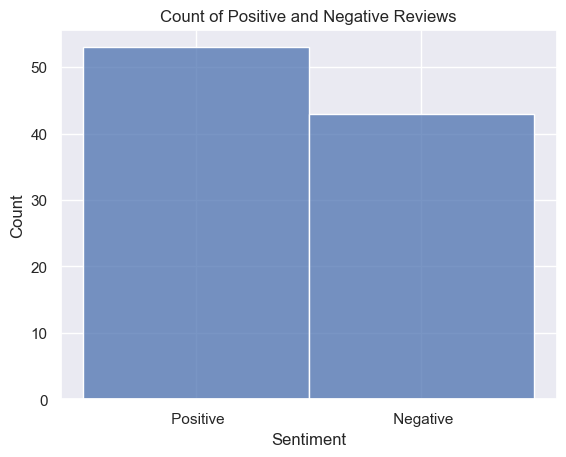

In [19]:
sns.histplot(data=data,x='Sentiment');
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Positive and Negative Reviews')
plt.show()

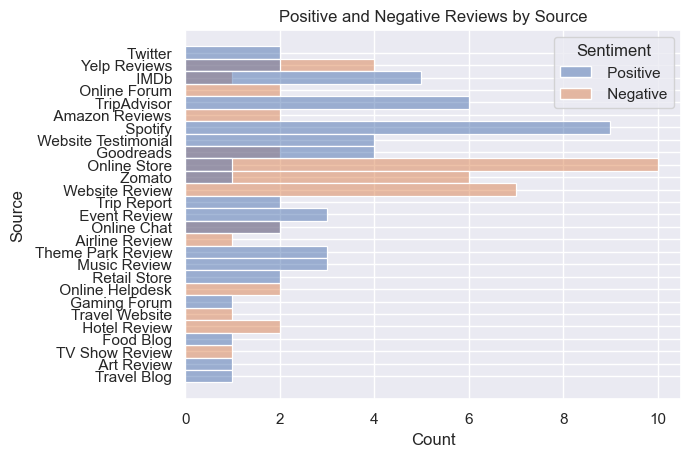

In [20]:
sns.histplot(data=data,y='Source',hue='Sentiment');
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Positive and Negative Reviews by Source')
plt.show()

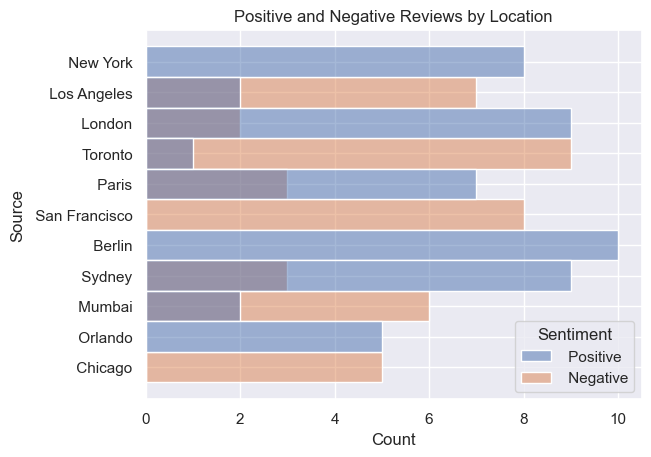

In [21]:
sns.histplot(data=data,y='Location',hue='Sentiment');
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Positive and Negative Reviews by Location')
plt.show()

In [22]:
data['Confidence Score']=data['Confidence Score'].astype(float)

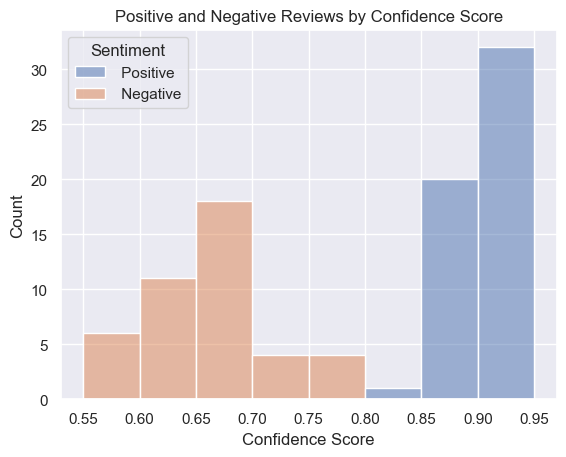

In [23]:
sns.histplot(data=data,x='Confidence Score',hue='Sentiment');
plt.title('Positive and Negative Reviews by Confidence Score')
plt.show()

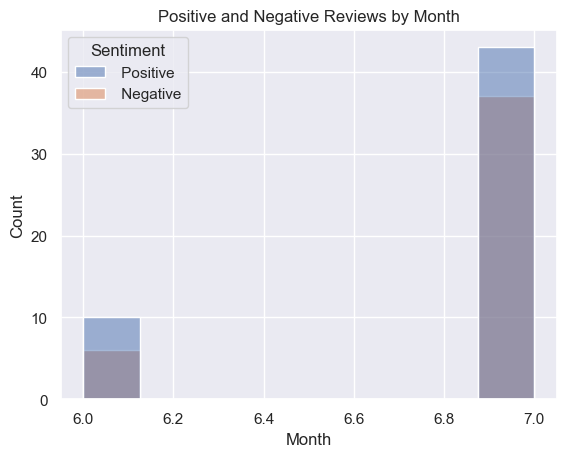

In [24]:
sns.histplot(data=data,x='Month',hue='Sentiment');
plt.title('Positive and Negative Reviews by Month')
plt.show()

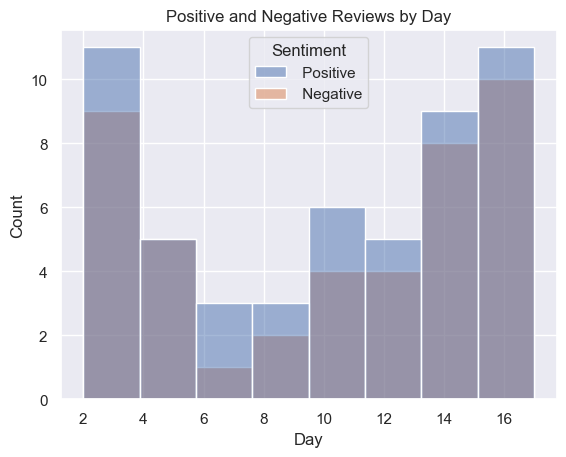

In [25]:
sns.histplot(data=data,x='Day',hue='Sentiment');
plt.title('Positive and Negative Reviews by Day')
plt.show()

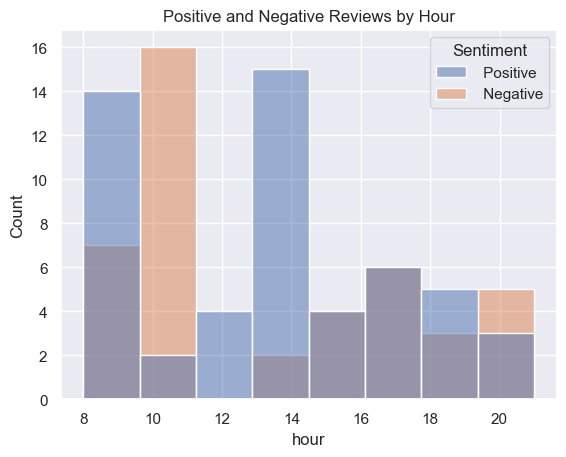

In [26]:
sns.histplot(data=data,x='hour',hue='Sentiment');
plt.title('Positive and Negative Reviews by Hour')
plt.show()

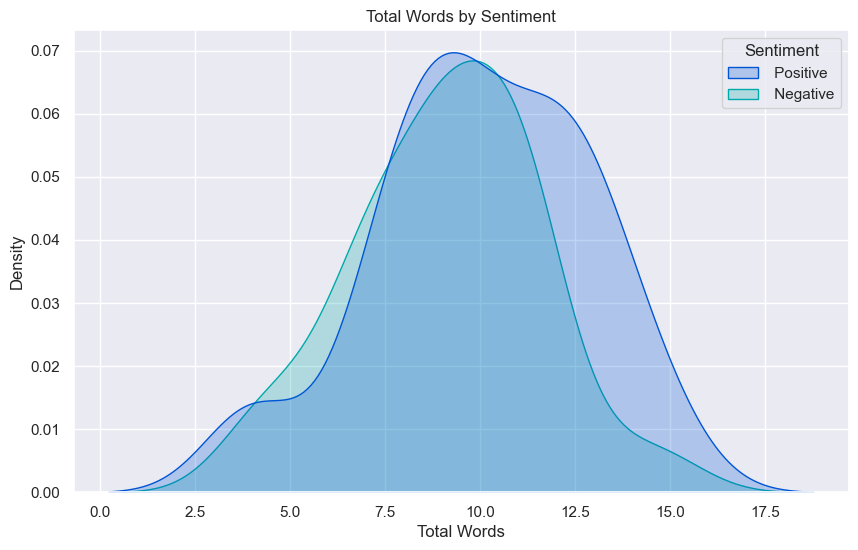

In [27]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['Sentiment'], palette= 'winter', shade = True)
plt.title('Total Words by Sentiment')
plt.show()

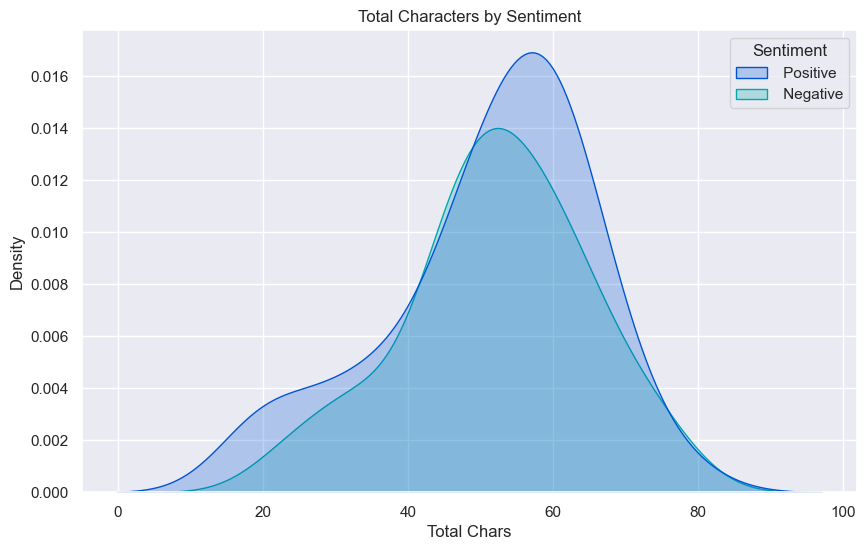

In [28]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['Sentiment'], palette= 'winter', shade = True)
plt.title('Total Characters by Sentiment')
plt.show()

In [29]:
text = " ".join(data[data['Sentiment'] == ' Negative']['Text'])
text = " ".join(data[data['Sentiment'] == ' Positive']['Text'])

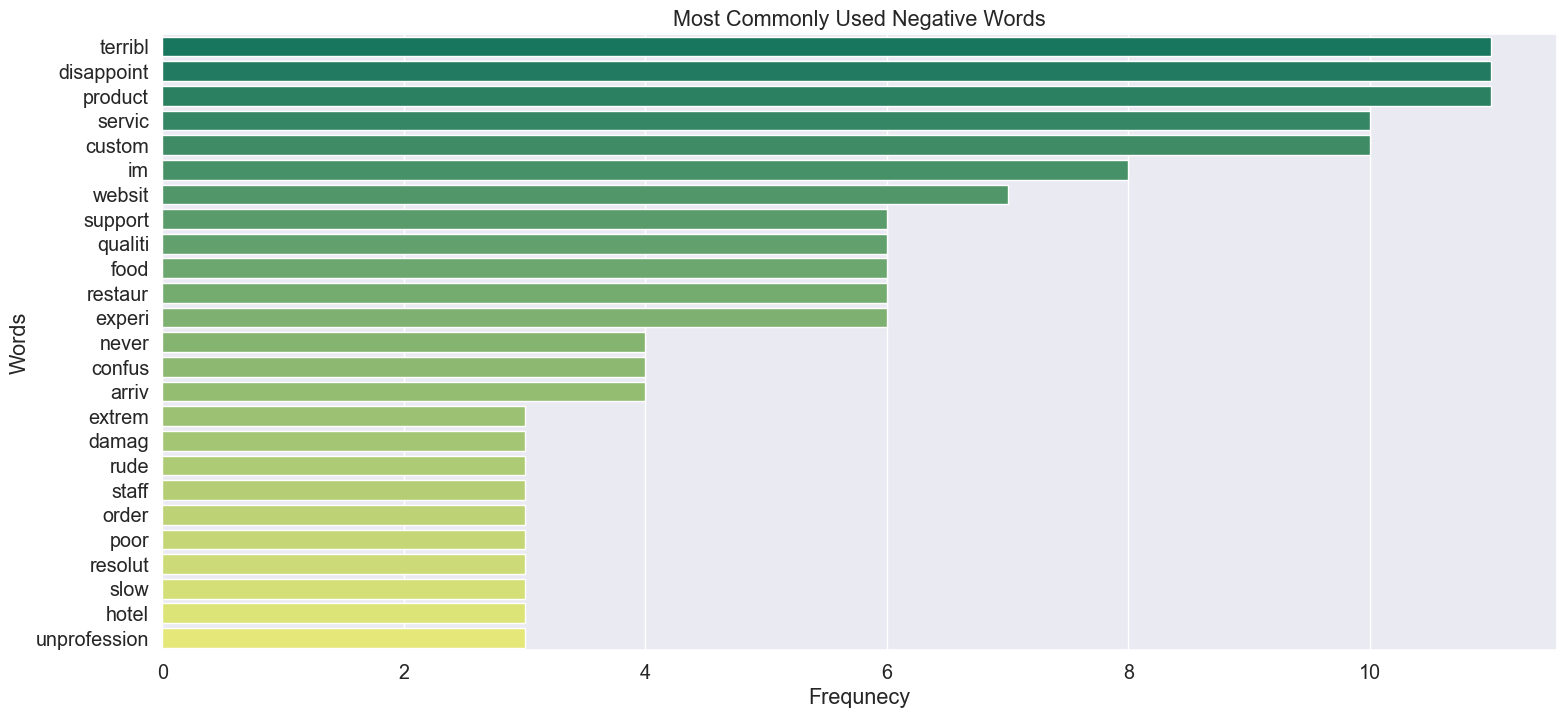

In [30]:
all_negative_words = []
for sentence in data[data['Sentiment'] == ' Negative']['Text'].to_list():
    for word in sentence.split():
        all_negative_words.append(word)

df = pd.DataFrame(Counter(all_negative_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Negative Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

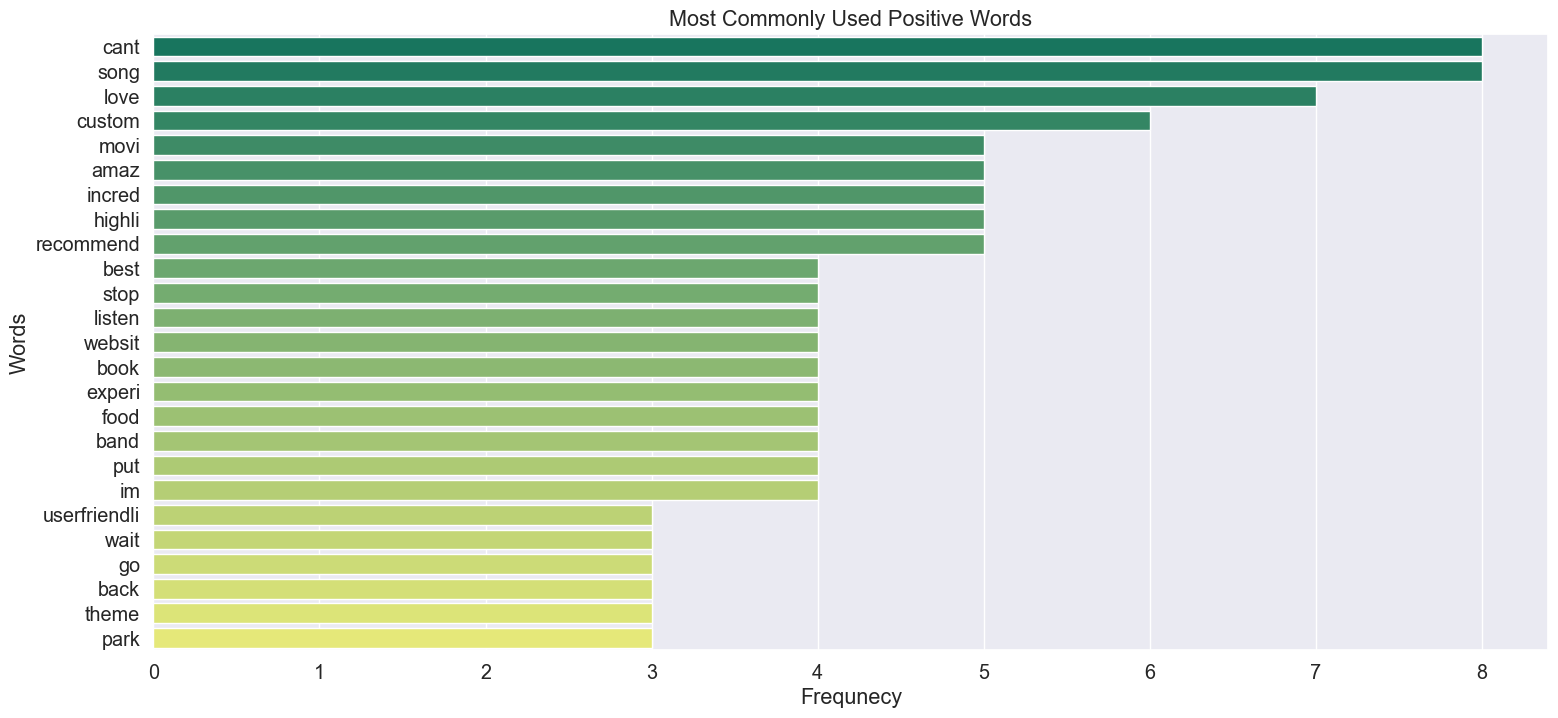

In [31]:
all_positive_words = []
for sentence in data[data['Sentiment'] == ' Positive']['Text'].to_list():
    for word in sentence.split():
        all_positive_words.append(word)

df = pd.DataFrame(Counter(all_positive_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Positive Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

## Modeling

### Sentiment Classification With Text

In [32]:
data['Sentiment']=data['Sentiment'].replace({' Negative': 0, ' Positive': 1})

In [33]:
X = data["Text"]
y = data['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [34]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [35]:
X_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.76694164, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

### Naive Bayes

Accuracy of the model: 0.95
Precision Score of the model: 1.0
Recall Score of the model: 0.909


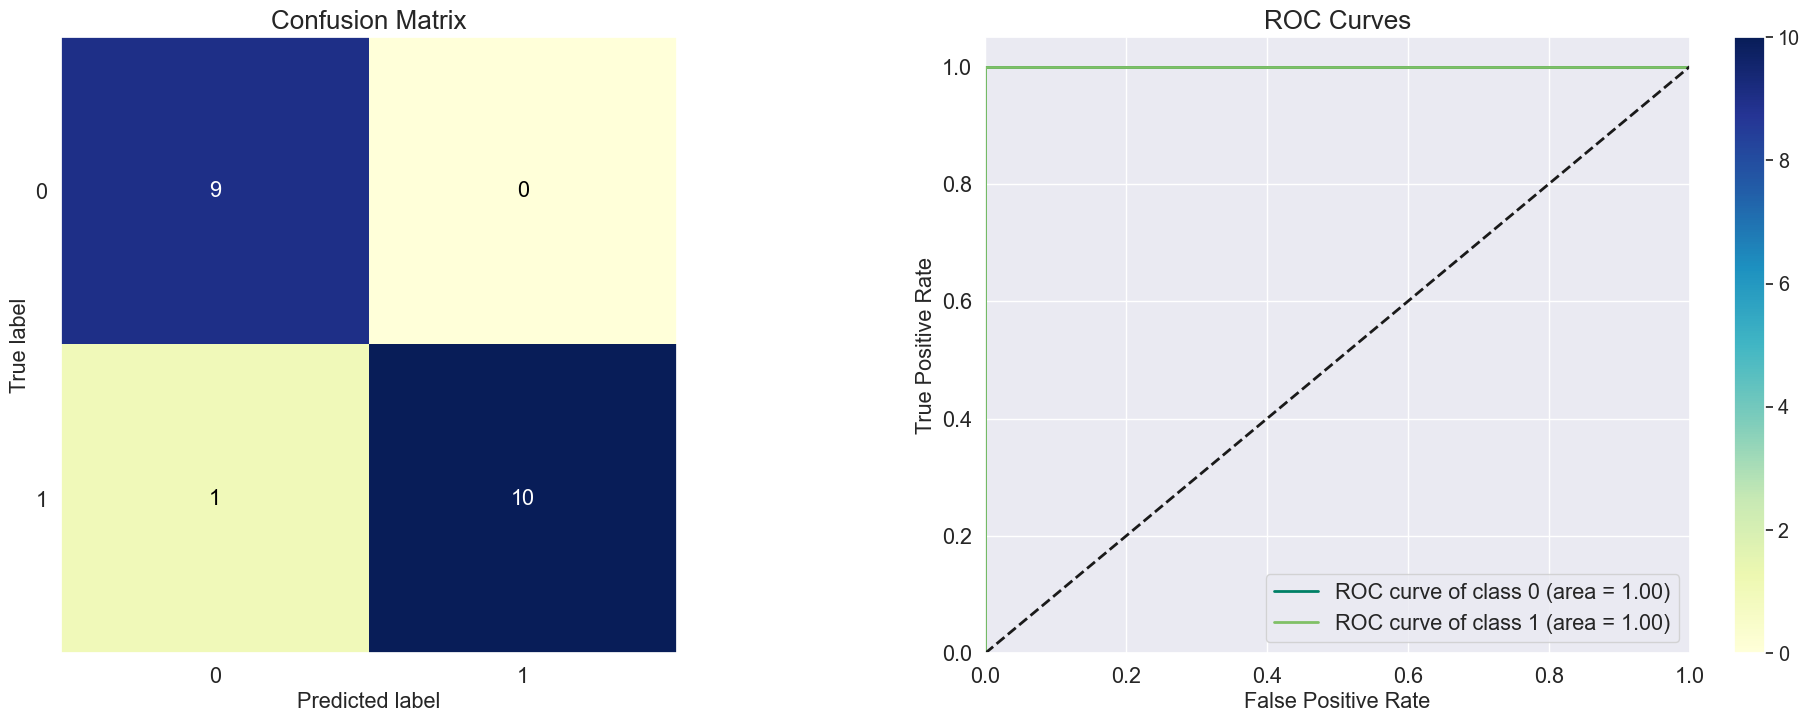

In [37]:
nb = MultinomialNB()
train_model(nb)

### Random Forest

Accuracy of the model: 0.9
Precision Score of the model: 0.909
Recall Score of the model: 0.909


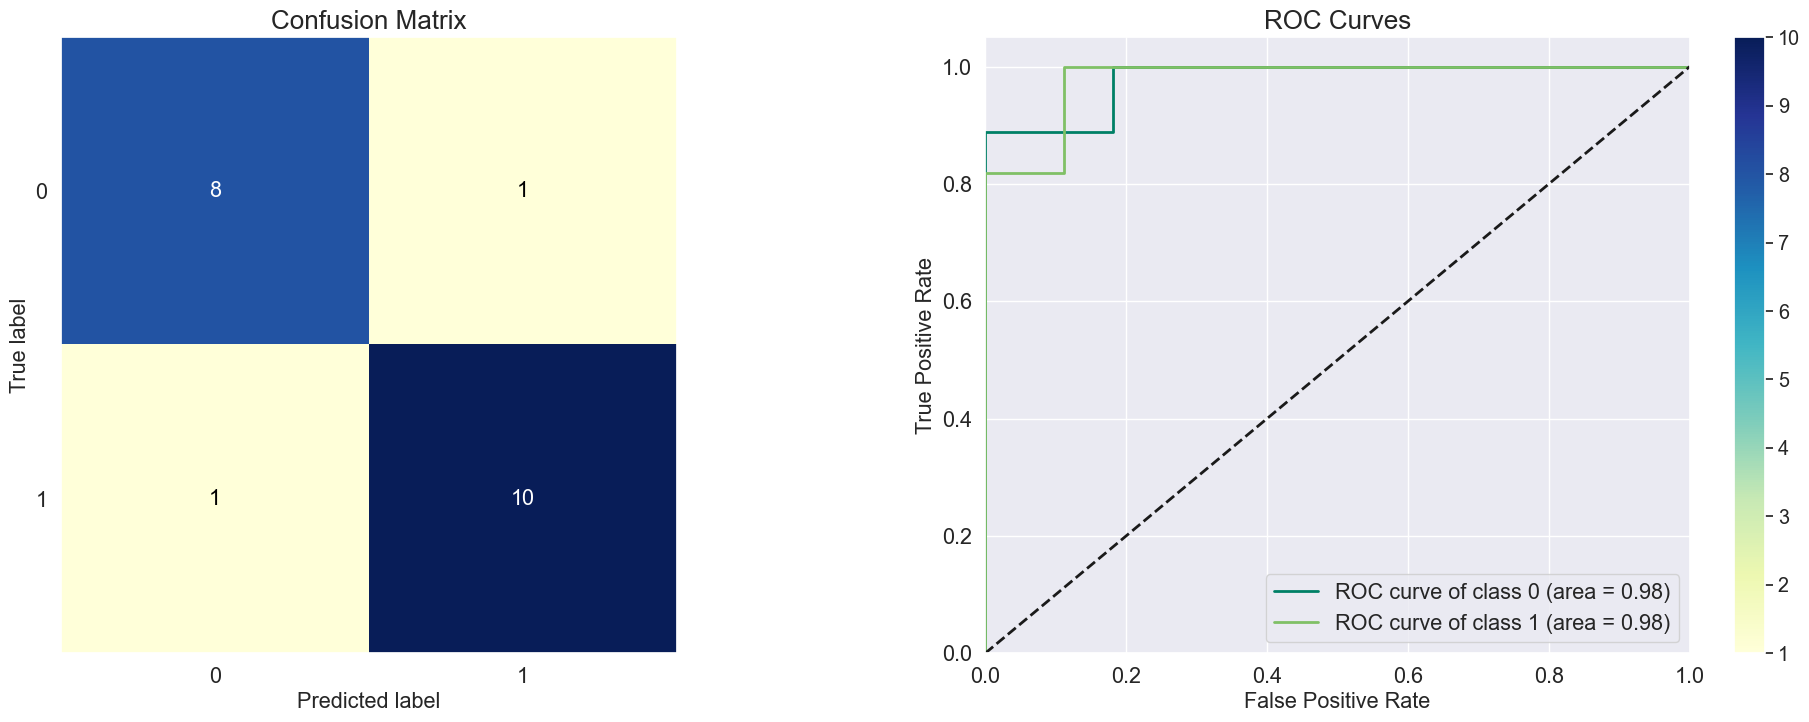

In [38]:
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

### LSTM

In [39]:
X = data["Text"]
y = data['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [40]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['Text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(data['Text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 love product 

After Tokenization & Padding 
 [14  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [41]:
y = data.Sentiment
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (53, 100) (53,)
Validation Set: (23, 100) (23,)
Test Set:       (20, 100) (20,)


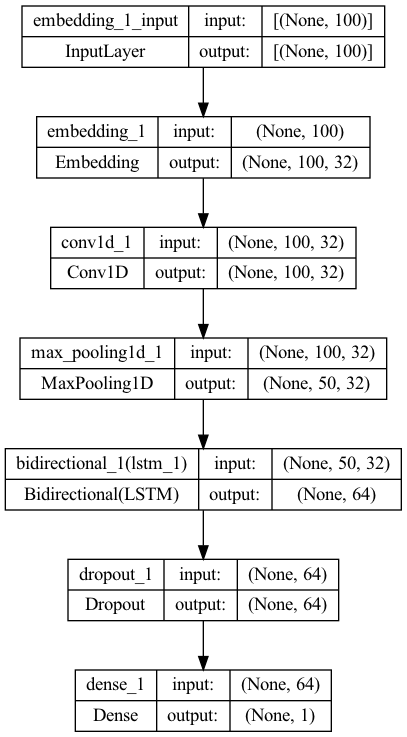

In [49]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

plot_model(model, show_shapes = True)

In [50]:
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=[tf.keras.metrics.Recall(),'accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [51]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.6917 - recall: 0.7241 - accuracy: 0.5660 - val_loss: 0.6902 - val_recall: 1.0000 - val_accuracy: 0.5652
Epoch 2/50
1/1 [==============================] - 0s 84ms/step - loss: 0.6907 - recall: 1.0000 - accuracy: 0.5660 - val_loss: 0.6888 - val_recall: 1.0000 - val_accuracy: 0.5652
Epoch 3/50
1/1 [==============================] - 0s 102ms/step - loss: 0.6908 - recall: 1.0000 - accuracy: 0.5472 - val_loss: 0.6882 - val_recall: 1.0000 - val_accuracy: 0.5652
Epoch 4/50
1/1 [==============================] - 0s 103ms/step - loss: 0.6873 - recall: 1.0000 - accuracy: 0.5472 - val_loss: 0.6869 - val_recall: 1.0000 - val_accuracy: 0.5652
Epoch 5/50
1/1 [==============================] - 0s 99ms/step - loss: 0.6856 - recall: 1.0000 - accuracy: 0.5472 - val_loss: 0.6858 - val_recall: 1.0000 - val_accuracy: 0.5652
Epoch 6/50
1/1 [==============================] - 0s 121ms/step - loss: 0.6895 - recall: 1.0000 - accuracy: 0.5472 

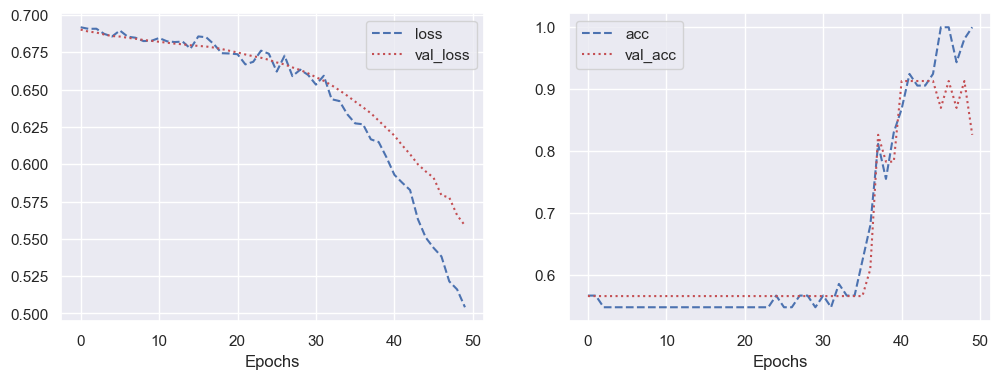

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [55]:
loss, accuracy,recall= model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Recall  : {:.4f}'.format(recall))

Accuracy  : 1.0000
Recall  : 1.0000


### Sentiment Classification Without Text

In [56]:
data2=data.loc[:,['Source','Location','Total Words','Total Chars','Total Words After Transformation','Month','Day','hour','Sentiment']]

In [57]:
data2=pd.get_dummies(data2)

In [58]:
data2

,Total Words,Total Chars,Total Words After Transformation,Month,Day,hour,Sentiment,Source_ Airline Review,Source_ Amazon Reviews,Source_ Art Review,...,Location_ Chicago,Location_ London,Location_ Los Angeles,Location_ Mumbai,Location_ New York,Location_ Orlando,Location_ Paris,Location_ San Francisco,Location_ Sydney,Location_ Toronto
0,4,19,0.693147,6,15,9,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4,24,0.693147,6,15,11,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,4,21,0.693147,6,15,14,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,44,1.386294,6,15,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,8,29,1.098612,6,16,8,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,12,51,1.791759,7,2,18,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
92,11,54,1.791759,7,2,20,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
93,11,50,1.791759,7,3,9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,8,45,1.386294,7,3,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [59]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Total Words                       96 non-null     int64  
 1   Total Chars                       96 non-null     int64  
 2   Total Words After Transformation  96 non-null     float64
 3   Month                             96 non-null     int64  
 4   Day                               96 non-null     int64  
 5   hour                              96 non-null     int64  
 6   Sentiment                         96 non-null     int64  
 7   Source_ Airline Review            96 non-null     uint8  
 8   Source_ Amazon Reviews            96 non-null     uint8  
 9   Source_ Art Review                96 non-null     uint8  
 10  Source_ Event Review              96 non-null     uint8  
 11  Source_ Food Blog                 96 non-null     uint8  
 12  Source_ Ga

In [60]:
X = data2.drop('Sentiment',axis=1)
y = data2['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

### Naive Bayes

Accuracy of the model: 0.9
Precision Score of the model: 0.909
Recall Score of the model: 0.909


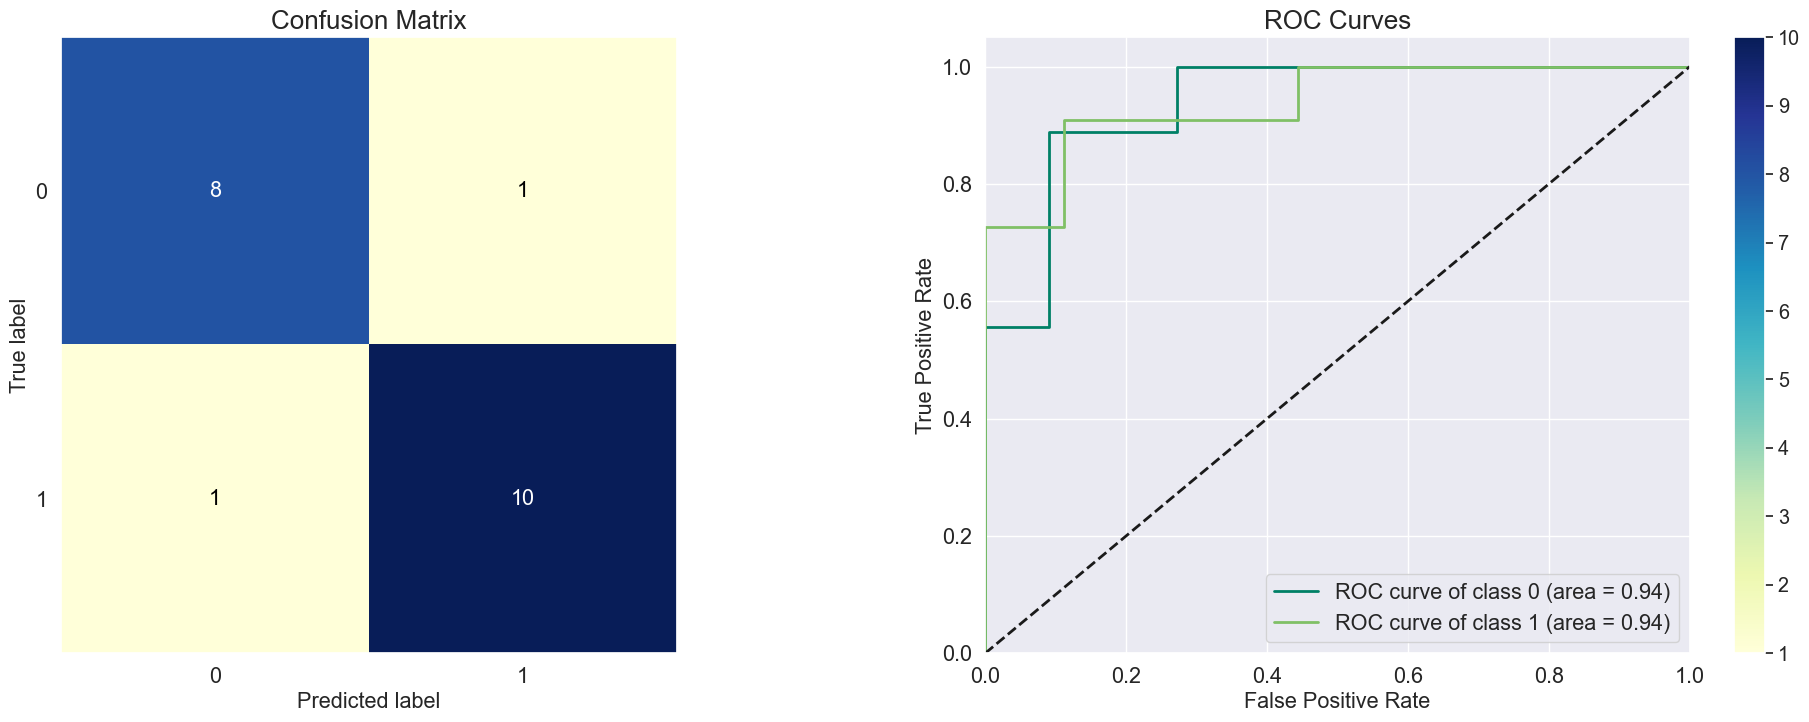

In [61]:
nb = MultinomialNB()
train_model(nb)

### Random Forest Classifier

Accuracy of the model: 0.7
Precision Score of the model: 0.727
Recall Score of the model: 0.727


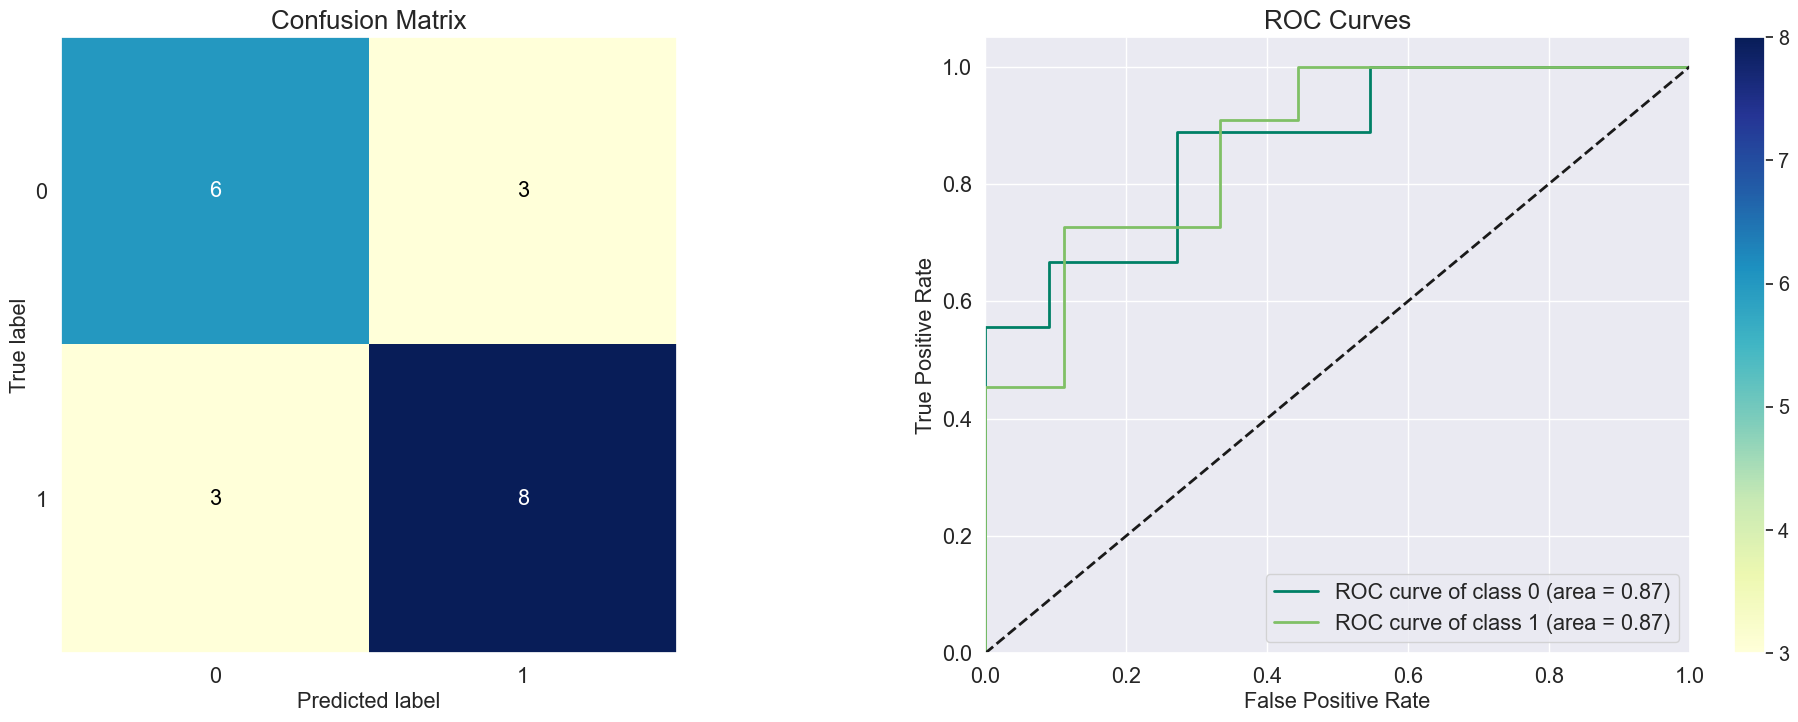

In [63]:
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)